# CNN/DailyMail dataset EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata
import string 
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud
%matplotlib inline
pd.set_option('display.max_colwidth', 180)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wojte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wojte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wojte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wojte\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wojte\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loading the data

In [2]:
train = pd.read_csv("data/cnn_dailymail/train.csv")

In [3]:
valid = pd.read_csv("data/cnn_dailymail/validation.csv")
test = pd.read_csv("data/cnn_dailymail/test.csv")

## Data overview

In [4]:
train.shape, valid.shape, test.shape

((287113, 3), (13368, 3), (11490, 3))

In [5]:
train.info(), valid.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287113 entries, 0 to 287112
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          287113 non-null  object
 1   article     287113 non-null  object
 2   highlights  287113 non-null  object
dtypes: object(3)
memory usage: 6.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13368 entries, 0 to 13367
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          13368 non-null  object
 1   article     13368 non-null  object
 2   highlights  13368 non-null  object
dtypes: object(3)
memory usage: 313.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11490 entries, 0 to 11489
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11490 non-null  object
 1   article     11490 non-null  object
 2   highlights  11490 non-

(None, None, None)

In [6]:
train["article"][0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

## Removing duplicates

In [7]:
train = train.drop_duplicates("highlights").reset_index(drop=True)
valid = valid.drop_duplicates("highlights").reset_index(drop=True)
test = test.drop_duplicates("highlights").reset_index(drop=True)

In [8]:
train.shape, valid.shape, test.shape

((282197, 3), (13300, 3), (11449, 3))

## Missing values

In [9]:
train.isnull().sum(), valid.isnull().sum(), test.isnull().sum()

(id            0
 article       0
 highlights    0
 dtype: int64,
 id            0
 article       0
 highlights    0
 dtype: int64,
 id            0
 article       0
 highlights    0
 dtype: int64)

## Fixing unicode characters

In [10]:
train["article"].str.contains("\\xa0").sum()

69552

In [11]:
def normalize_unicode(data):
    data["article"] = data["article"].apply(lambda x: unicodedata.normalize("NFKD", x))
    data["highlights"] = data["highlights"].apply(lambda x: unicodedata.normalize("NFKD", x))
    return data

In [12]:
train = normalize_unicode(train)
valid = normalize_unicode(valid)
test = normalize_unicode(test)

In [13]:
train["article"].str.contains("\\xa0").sum()

0

## Creating new features

In [14]:
# source of text
train["cnn"] = train["article"].str.contains("\(CNN[A-Za-z ]*\)")
train["associated_press"] = train["article"].str.contains("By \. Associated Press")
train["daily_mail"] = train["article"].str.contains("By \. Daily Mail")

In [15]:
train[["cnn","associated_press","daily_mail"]].sum()

cnn                 72756
associated_press     2836
daily_mail          13958
dtype: int64

## Removing noise

In [16]:
def remove_noise(data):
    data["article"] = data["article"].apply(lambda x: re.sub(r"(By \. [A-Za-z ]+ \. )", "", x))
    data["article"] = data["article"].apply(lambda x: re.sub(r"(PUBLISHED: \. \d{2}:\d{2} \w+, \d+ \w+ \d{4} \. )", "", x))
    data["article"] = data["article"].apply(lambda x: re.sub(r"(\| \. UPDATED: \. \d{2}:\d{2} \w+, \d+ \w+ \d{4} \. )", "", x))
    data["article"] = data["article"].apply(lambda x: re.sub(r"(\(CNN[A-Za-z ]*\)\s*-?-? ?)", "", x))
    return data

In [17]:
train = remove_noise(train)

In [18]:
train["article"][0]

"The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained bishops in Italy last month. Symptoms of hepatitis A include fever, tiredness, loss of appetite, nausea and ab

In [19]:
valid = remove_noise(valid)

In [20]:
test = remove_noise(test)

## Calculating lengths of articles and highlights

In [21]:
def add_lengths(data):
    data["article_len"] = data["article"].apply(len)
    data["highlights_len"] = data["highlights"].apply(len)
    return data

In [22]:
train = add_lengths(train)
valid = add_lengths(valid)
test = add_lengths(test)

### Plot dependence between article lenght and highlights length

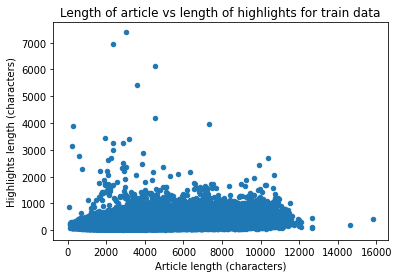

In [23]:
train.plot(kind="scatter", x="article_len", y="highlights_len", title="Length of article vs length of highlights for train data")
plt.xlabel("Article length (characters)")
plt.ylabel("Highlights length (characters)")
plt.savefig("figures/article_vs_highlight_train.png")

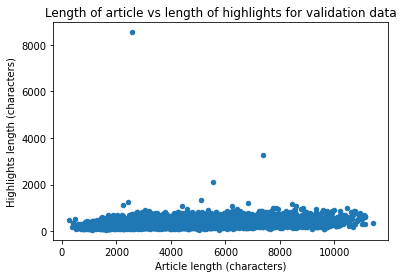

In [24]:
valid.plot(kind="scatter", x="article_len", y="highlights_len", title="Length of article vs length of highlights for validation data")
plt.xlabel("Article length (characters)")
plt.ylabel("Highlights length (characters)")
plt.savefig("figures/article_vs_highlight_valid.png")

#### Example of highlights longer than article

In [92]:
valid[valid["highlights_len"] > 8000]["article"].values[0]

"He was the despised ‘crookback’ king of Tudor legend, a murderous stage villain whose brief reign went down in infamy. Yet with the 2012 discovery of his mutilated remains in a Leicester car park, Richard III’s reputation has been transformed. And starting today comes a remarkable national celebration for the last English king to fall in battle. From the embroidered linen bags containing his tiny hands and feet, to the simple tomb carved in Swaledale rock, the five days of ceremony are packed with thought-provoking detail. Scroll down for video . Family connection: Coffin-maker Michael Ibsen, who is a distant relative of Richard III, alongside a reconstruction of the King . His final journey will start at 1.05pm today close to Bosworth Field where he was killed in 1485 before ending at Leicester Cathedral, where our last Plantagenet king will lie in repose until his burial on Thursday. Richard will be attended by his closest living relatives and peers descended from the noblemen who f

In [93]:
valid[valid["highlights_len"] > 8000]["highlights"].values[0]

"Five day celebration for the last English king to fall in battle begins today .\nFinal journey begins at Bosworth Field and ends at Leicester Cathedral .\nRichard will be buried on Thursday after he's attended by living relatives .\nDNA analysis confirmed remains found in car park in 2012 were Richard’s .\nRichard III’s coffin leaves Leicester University for Bosworth Field in a black Jaguar hearse, escorted by four police outriders and limousines, to start the preliminary leg of its journey. The oak coffin was made by Michael Ibsen, Richard’s nephew 17 times removed, whose family’s DNA was used to identify the King’s skeleton.\nThe bones have been packed in wool and Richard’s hands and feet have been placed in linen bags, embroidered with roses by children at Leicester’s Richard III Primary School. With the King is a wooden rosary, emblazoned with an enamelled White Rose. The skeleton is covered by a raw linen cloth, embroidered with York roses, by Elizabeth Noakes, of the Richard III

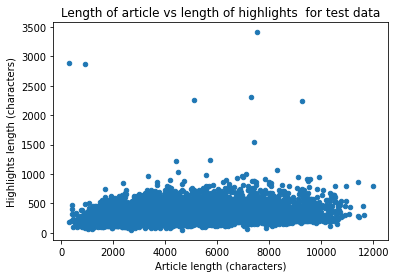

In [25]:
test.plot(kind="scatter", x="article_len", y="highlights_len", title="Length of article vs length of highlights  for test data")
plt.xlabel("Article length (characters)")
plt.ylabel("Highlights length (characters)")
plt.savefig("figures/article_vs_highlight_test.png")

### Removing too long highlights

In [26]:
def drop_long_highlights(data):
    rows_to_drop = data[data["highlights_len"] > 0.5*data["article_len"]].index.values
    print(f"Droped {len(rows_to_drop)} rows")
    return data.drop(rows_to_drop, axis=0)

In [27]:
train = drop_long_highlights(train)

Droped 134 rows


In [28]:
valid = drop_long_highlights(valid)
test = drop_long_highlights(test)

Droped 10 rows
Droped 12 rows


## Sentence and word tokenization

In [31]:
def add_sentences(data):
    data["article_sent"] = data["article"].apply(lambda x: re.split(r"[\.\?!;]",x))
    data["highlights_sent"] = data["highlights"].apply(lambda x: re.split(r"[\.\?!;]",x))
    data["article_sent_count"] = data["article_sent"].apply(len)
    data["highlights_sent_count"] = data["highlights_sent"].apply(len)
    return data

def add_words(data):
    data["article_word"] = data["article"].apply(lambda x: re.split(r"[ ']",x))
    data["highlights_word"] = data["highlights"].apply(lambda x: re.split(r"[ ']",x))
    data["article_word_count"] = data["article_word"].apply(len)
    data["highlights_word_count"] = data["highlights_word"].apply(len)
    return data

In [36]:
train = add_sentences(train)
train = add_words(train)

In [32]:
valid = add_sentences(valid)

In [33]:
test = add_sentences(test)

In [34]:
valid = add_words(valid)

In [35]:
test = add_words(test)

## Word count and frequency

In [37]:
stopwords_english = stopwords.words('english')
punctuation = string.punctuation

In [38]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
punctuation = punctuation + "’" + "‘"

In [40]:
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [41]:
lemma = WordNetLemmatizer()
word_count = {}
i = 0
for article in valid["article_word"].values:
    i+=1
    if not i%1000: print(i)
    nltk_tagged = nltk.pos_tag(article)
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    for word, tag in wordnet_tagged:
        word = word.translate(str.maketrans('', '', punctuation))
        word = word.lower()
        if tag is not None:
            word = lemma.lemmatize(word, tag)
            if word and word not in stopwords_english:   
                if word in word_count.keys():
                    word_count[word] +=1
                else:
                    word_count[word] = 1

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000


In [211]:
[k for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)][:20]

['say',
 'year',
 'take',
 'make',
 'go',
 'time',
 'get',
 'nt',
 'also',
 'last',
 'tell',
 'leave',
 'people',
 'mr',
 'new',
 'first',
 'come',
 'show',
 'see',
 'police']

In [215]:
[v for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)][:20]

[64322,
 22241,
 19932,
 18732,
 18695,
 17519,
 17140,
 16703,
 16649,
 15689,
 14334,
 13840,
 13817,
 13809,
 13478,
 13050,
 12331,
 12260,
 11999,
 11993]

In [217]:
valid_word_freq = pd.DataFrame.from_dict(word_count, orient="index")

In [222]:
valid_word_freq.columns = ["count"]

In [228]:
valid_word_freq["freq"] = valid_word_freq["count"].apply(lambda x: x/valid_word_freq["count"].sum())

In [230]:
valid_word_freq.sort_values("count", ascending=False).to_csv("data/valid_word_freq.csv")

In [243]:
wordcloud = WordCloud(width=800, height=400)

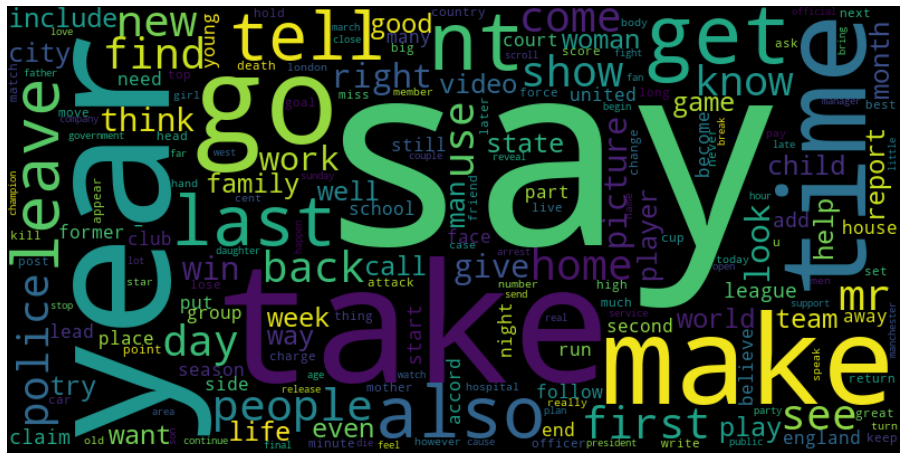

In [245]:
wordcloud.generate_from_frequencies(frequencies=valid_word_freq.sort_values("count", ascending=False).iloc[:500,:1].to_dict()["count"])
plt.figure(figsize=(16,9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("figures/val_word_cloud.png")

### Histograms of lengths

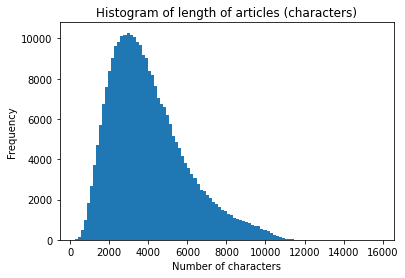

In [129]:
train["article_len"].plot(kind="hist", bins=100, title="Histogram of length of articles (characters)")
plt.xlabel("Number of characters")
plt.savefig("figures/article_len_char.png")

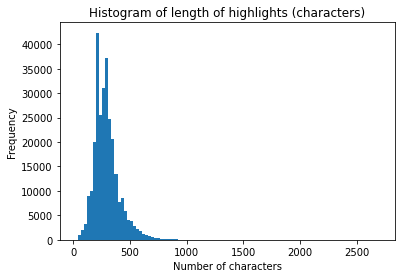

In [130]:
train["highlights_len"].plot(kind="hist", bins=100, title="Histogram of length of highlights (characters)")
plt.xlabel("Number of characters")
plt.savefig("figures/highlights_len_char.png")

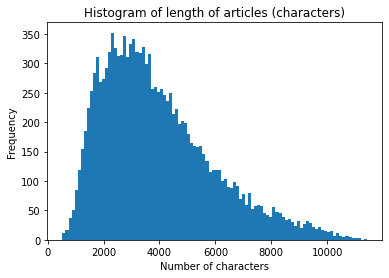

In [143]:
valid["article_len"].plot(kind="hist", bins=100, title="Histogram of length of articles (characters)")
plt.xlabel("Number of characters")
plt.savefig("figures/val_article_len_char.png")

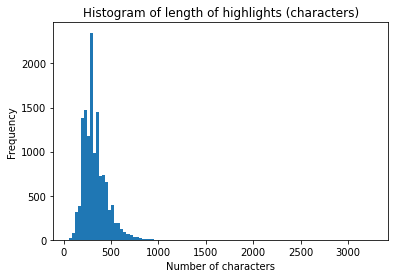

In [144]:
valid["highlights_len"].plot(kind="hist", bins=100, title="Histogram of length of highlights (characters)")
plt.xlabel("Number of characters")
plt.savefig("figures/val_highlights_len_char.png")

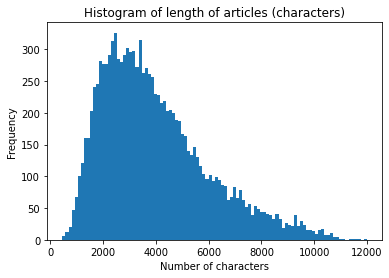

In [155]:
test["article_len"].plot(kind="hist", bins=100, title="Histogram of length of articles (characters)")
plt.xlabel("Number of characters")
plt.savefig("figures/test_article_len_char.png")

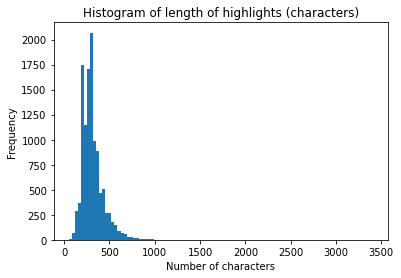

In [156]:
test["highlights_len"].plot(kind="hist", bins=100, title="Histogram of length of highlights (characters)")
plt.xlabel("Number of characters")
plt.savefig("figures/test_highlights_len_char.png")

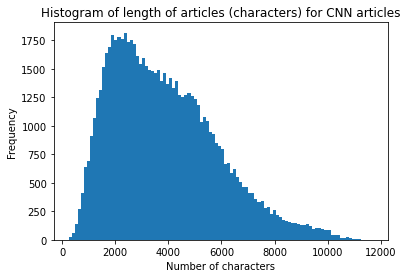

In [157]:
train.loc[train["cnn"],"article_len"].plot(kind="hist", bins=100, title="Histogram of length of articles (characters) for CNN articles")
plt.xlabel("Number of characters")
plt.savefig("figures/cnn_article_len_char.png")

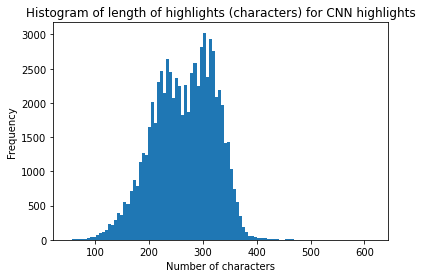

In [158]:
train.loc[train["cnn"],"highlights_len"].plot(kind="hist", bins=100, title="Histogram of length of highlights (characters) for CNN highlights")
plt.xlabel("Number of characters")
plt.savefig("figures/cnn_highlights_len_char.png")

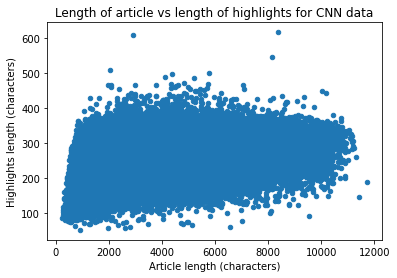

In [159]:
train[train["cnn"]].plot(kind="scatter", x="article_len", y="highlights_len", title="Length of article vs length of highlights for CNN data")
plt.xlabel("Article length (characters)")
plt.ylabel("Highlights length (characters)")
plt.savefig("figures/article_vs_highlight_cnn.png")

In [38]:
from preprocessing import load_data
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
train, valid, test = load_data("data/cnn_dailymail/")

In [14]:
lens = test.highlights.apply(lambda x: len(re.split(r"[.?!;]", x)))

In [30]:
test.article[0]

['Ever noticed how plane seats appear to be getting smaller and smaller',
 'With increasing numbers of people taking to the skies, some experts are questioning if having such packed out planes is putting passengers at risk',
 "They say that the shrinking space on aeroplanes is not only uncomfortable - it's putting our health and safety in danger",
 'More than squabbling over the arm rest, shrinking space on planes putting our health and safety in danger',
 "This week, a U.S consumer advisory group set up by the Department of Transportation said at a public hearing that while the government is happy to set standards for animals flying on planes, it doesn't stipulate a minimum amount of space for humans",
 "'In a world where animals have more rights to space and food than humans,' said Charlie Leocha, consumer representative on the committee",
 "'It is time that the DOT and FAA take a stand for humane treatment of passengers",
 ' But could crowding on planes lead to more serious issues t

In [56]:
vectorizer = TfidfVectorizer()

In [57]:
X = vectorizer.fit_transform(test.article[0])

In [58]:
vectorizer.get_feature_names_out()

array(['28', '29', '30', '31', '32', 'above', 'administration',
       'advisory', 'aeroplanes', 'air', 'airlines', 'airways', 'amount',
       'and', 'animals', 'appear', 'are', 'arm', 'as', 'asia', 'at',
       'atlantic', 'aviation', 'back', 'be', 'behind', 'below', 'between',
       'british', 'but', 'by', 'can', 'charlie', 'committee', 'conducted',
       'conducts', 'consumer', 'corbertt', 'could', 'crashing',
       'crowding', 'cynthia', 'danger', 'decreased', 'department',
       'detroit', 'distance', 'doesn', 'dot', 'each', 'easyjet',
       'economy', 'elbows', 'ever', 'experts', 'faa', 'factors', 'fall',
       'federal', 'fighting', 'flying', 'food', 'for', 'from', 'getting',
       'government', 'group', 'gulf', 'happy', 'has', 'haul', 'have',
       'having', 'health', 'hearing', 'how', 'human', 'humane', 'humans',
       'if', 'in', 'inch', 'inches', 'increasing', 'is', 'issues', 'it',
       'just', 'kicking', 'known', 'lead', 'leave', 'leocha', 'little',
       'lock

In [61]:
X2 = vectorizer.fit_transform(test.article[0] + [" ".join(test.article[0])])

In [62]:
X2.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.17358985,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.14058869, 0.30868493, 0.14058869, ..., 0.11984973, 0.        ,
         0.        ],
        [0.15790507, 0.17335291, 0.15790507, ..., 0.13461169, 0.        ,
         0.        ],
        [0.09171999, 0.10069294, 0.09171999, ..., 0.1303165 , 0.11251806,
         0.03742037]])

In [63]:
pd.DataFrame(data=X2.todense(), columns=vectorizer.get_feature_names_out())

,28,29,30,31,32,above,administration,advisory,aeroplanes,air,...,up,use,using,virgin,week,where,which,while,with,world
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.173590,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.267747,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.17171,0.000000,0.000000,...,0.17171,0.000000,0.000000,0.000000,0.17171,0.000000,0.000000,0.119596,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.255017,0.000000,0.000000,0.000000,0.255017
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.220476,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.293296,0.000000,0.000000,0.00000,0.000000,0.263073,0.000000,0.220476,0.000000
9,0.199673,0.000000,0.199673,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.170218,0.000000,0.000000


In [39]:
vectorizer2 = CountVectorizer()
X_c = vectorizer2.fit_transform(test.article[0])
vectorizer2.get_feature_names_out()

array(['28', '29', '30', '31', '32', 'above', 'administration',
       'advisory', 'aeroplanes', 'air', 'airlines', 'airways', 'amount',
       'and', 'animals', 'appear', 'are', 'arm', 'as', 'asia', 'at',
       'atlantic', 'aviation', 'back', 'be', 'behind', 'below', 'between',
       'british', 'but', 'by', 'can', 'charlie', 'committee', 'conducted',
       'conducts', 'consumer', 'corbertt', 'could', 'crashing',
       'crowding', 'cynthia', 'danger', 'decreased', 'department',
       'detroit', 'distance', 'doesn', 'dot', 'each', 'easyjet',
       'economy', 'elbows', 'ever', 'experts', 'faa', 'factors', 'fall',
       'federal', 'fighting', 'flying', 'food', 'for', 'from', 'getting',
       'government', 'group', 'gulf', 'happy', 'has', 'haul', 'have',
       'having', 'health', 'hearing', 'how', 'human', 'humane', 'humans',
       'if', 'in', 'inch', 'inches', 'increasing', 'is', 'issues', 'it',
       'just', 'kicking', 'known', 'lead', 'leave', 'leocha', 'little',
       'lock

In [41]:
pd.DataFrame(data=X_c.todense(), columns=vectorizer2.get_feature_names_out())

,28,29,30,31,32,above,administration,advisory,aeroplanes,air,...,up,use,using,virgin,week,where,which,while,with,world
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
9,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
